*Author: Daniel Puente Viejo*  

<img src="https://cdn-icons-png.flaticon.com/512/4148/4148575.png" width="100" height="100" float ="right">    

In this notebook we intend to generate multiple models, both easily explainable and difficult and see how well they perform. Once you enter the graph you will be able to see the difference in results.  

- <a href='#1'><ins>1. Loading of Libraries and Data<ins></a>
- <a href='#2'><ins>2. Easy interpretability<ins> </a>
- <a href='#3'><ins>3. Hard interpretability<ins></a>
- <a href='#4'><ins>4. Really hard interpretability<ins></a>
- <a href='#5'><ins>5. Saving relevant metrics<ins></a>

### <a id='1'>1. Loading of Libraries and Data</a>
----

* Common libraries

In [158]:
import pandas as pd
import numpy as np
import pickle
import itertools
import matplotlib.pyplot as plt

* Sklearn

In [159]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score

from skopt import BayesSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

* Pytorch

In [1]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import Linear
import torch.nn.functional as F

* Paths and warnings

In [160]:
import warnings
warnings.filterwarnings("ignore")

eda_path = "../data/eda_generated_data/"
path = "../data/graph_data/"

def load_pickle(path, file_name):
    with open(path + file_name, 'rb') as f: return pickle.load(f)
    
def save_pickle_file(file_name, file):
    with open(output_path + file_name, 'wb') as f: pickle.dump(file, f)

Data is loaded

In [161]:
df_train_graph = load_pickle(path, "df_train_graph.pkl")
df_val_graph = load_pickle(path, "df_val_graph.pkl")
df_test = load_pickle(eda_path, "df_test.pkl")
scaler = load_pickle(eda_path, "scaler.pkl")

Data is transformed

In [162]:
df_train_graph_numeric_scaled = scaler.transform(df_train_graph.select_dtypes(include=np.number).drop(columns=["SK_ID_CURR","TARGET"]))
df_val_graph_numeric_scaled = scaler.transform(df_val_graph.select_dtypes(include=np.number).drop(columns=["SK_ID_CURR","TARGET"]))

Test is scaled with the scaler fitted on train and val data

In [163]:
df_test_numeric = df_test.loc[:, df_train_graph.select_dtypes(include=np.number).drop(columns=["SK_ID_CURR","TARGET"]).columns]
df_test_graph_numeric_scaled = scaler.transform(df_test_numeric)
df_test_graph_numeric_scaled = df_test_graph_numeric_scaled[:2000]

### <a id='2'>2. Easy intepretability</a>
----

List of models and parameters to test

In [164]:
easy_model_list = [LogisticRegression(),  DecisionTreeClassifier()]
easy_model_params_list = [{"penalty": ["l1", "l2"], "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], "solver": ["liblinear"]},
                          {"criterion": ["gini", "entropy"], "max_depth": [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10], "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

Thanks to this function each model of the list will be trained and the results will be saved in a dictionary.   
BayesSearchCV is used to find the best parameters for each model.

In [165]:
def training_models(model_list, model_params_list, n_iter=10, cv=5, n_jobs=-1, verbose=1, scoring="roc_auc"):
    model_list_results = []
    for model, params in zip(model_list, model_params_list):

        print(model)
        bayes_cv_tuner = BayesSearchCV(model, params, n_iter=n_iter, cv=cv, n_jobs=-1, verbose=1, scoring="roc_auc")
        bayes_cv_tuner.fit(df_train_graph_numeric_scaled, df_train_graph["TARGET"])
        model_list_results.append(bayes_cv_tuner.best_estimator_)
        print("Best score: {}".format(bayes_cv_tuner.best_score_))
        print("Best params: {}".format(bayes_cv_tuner.best_params_))
        
    return model_list_results

In [26]:
model_list = training_models(easy_model_list, easy_model_params_list)

LogisticRegression()
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best score: 0.7317419640938062
Best params: OrderedDict([('C', 0.001), ('penalty', 'l2'), ('solver', 'liblinear')])
DecisionTreeClassifier()
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 fo

Function to return the main metrics

In [166]:
def metrics_return(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return f1, precision, recall, auc

Train, validation and test sets are predicted and metrics saved in a dataframe.

In [167]:
def results_model_iteration(model_list):

    metrics_train, metrics_val, metrics_test = [], [], []
    for model in model_list:
        y_pred_train = model.predict(df_train_graph_numeric_scaled)
        y_pred_val = model.predict(df_val_graph_numeric_scaled)
        y_pred_test = model.predict(df_test_graph_numeric_scaled)

        metrics_train.append(metrics_return(df_train_graph["TARGET"], y_pred_train))
        metrics_val.append(metrics_return(df_val_graph["TARGET"], y_pred_val))
        metrics_test.append(metrics_return(df_test["TARGET"][:2000], y_pred_test))
    
    return metrics_train, metrics_val, metrics_test

The results seem not to be very good, but we will see if we can improve them with the next models.   
However taking a look at the results the best model is:    
·   
👉 **DecisionTreeClassifier**

In [28]:
easy_metrics_train, easy_metrics_val, easy_metrics_test = results_model_iteration(model_list)

easy_metrics_train = pd.DataFrame(easy_metrics_train, columns=["f1_train", "precision_train", "recall_train", "auc_train"], index=["LogisticRegression", "DecisionTreeClassifier"])
easy_metrics_val = pd.DataFrame(easy_metrics_val, columns=["f1_val", "precision_val", "recall_val", "auc_val"], index=["LogisticRegression", "DecisionTreeClassifier"])
easy_metrics_test = pd.DataFrame(easy_metrics_test, columns=["f1_test", "precision_test", "recall_test", "auc_test"], index=["LogisticRegression", "DecisionTreeClassifier"])

display(easy_metrics_train, easy_metrics_val, easy_metrics_test)

,f1_train,precision_train,recall_train,auc_train
LogisticRegression,0.000000,0.000000,0.000000,0.500000
DecisionTreeClassifier,0.044719,0.659091,0.023144,0.511064


,f1_val,precision_val,recall_val,auc_val
LogisticRegression,0.000000,0.000000,0.000000,0.500000
DecisionTreeClassifier,0.024691,0.357143,0.012788,0.505418


,f1_test,precision_test,recall_test,auc_test
LogisticRegression,0.000000,0.000000,0.000000,0.500000
DecisionTreeClassifier,0.011299,0.142857,0.005882,0.501302


### <a id='3'>3. Hard intepretability</a>
----

The same procedure is carried out, but this time with ensembles models.

In [168]:
hard_model_list = [RandomForestClassifier(random_state=42, class_weight='balanced_subsample'), XGBClassifier(seed = 42, scale_pos_weight = 11.76), LGBMClassifier(random_state = 42, scale_pos_weight = 11.76), CatBoostClassifier(random_seed = 42, scale_pos_weight = 11.76, allow_writing_files = False)]

hard_model_params_list = [
                            {"n_estimators": [100, 200, 300, 400, 500], "criterion": ["gini", "entropy"], "max_depth": [None, 2, 4, 7, 10], "min_samples_split": [2, 4, 7, 10], "min_samples_leaf": [2,  4, 7, 10]},
                            {"n_estimators": [100, 200, 300, 400, 500], "max_depth": [None, 2, 4, 7, 10], "learning_rate": [0.001, 0.01, 0.1], "subsample": [0.5, 0.7, 0.9], "gamma": [0, 0.25, 0.5, 1], "reg_alpha": [0, 0.25, 0.5, 1], "reg_lambda": [0, 0.25, 0.5, 1]},
                            {"n_estimators": [100, 200, 300, 400, 500], "max_depth": [None, 2, 4, 7, 10], "learning_rate": [0.001, 0.01, 0.1], "subsample": [0.5, 0.7, 0.9], "reg_alpha": [0, 0.25, 0.5, 1], "reg_lambda": [0, 0.25, 0.5, 1]},
                            {"iterations": [100, 200, 300, 400, 500], "depth": [2, 4, 7, 10], "learning_rate": [0.001, 0.01, 0.1], "subsample": [0.5, 0.7, 0.9]}
                        ]

In [169]:
model_list_hard = training_models(hard_model_list, hard_model_params_list, n_iter=10, cv=5)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best score: 0.7285757318910644
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 7), ('min_samples_leaf', 10), ('min_samples_split', 4), ('n_estimators', 400)])
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categori

The results are a little bit better than the previous ones, nonetheless, it can be improved.    
RandomForest provides good results, however, it overfitts too much. Between the rest of the models, the selected model is LightGBM as it does not overtif as much as the others.    
Even if the other are a little bit better they overfit a little bit more.     
·      
👉 **LGBMClassifier**

In [176]:
hard_metrics_train, hard_metrics_val, hard_metrics_test = results_model_iteration(model_list_hard)
hard_metrics_train = pd.DataFrame(hard_metrics_train, columns=["f1_train", "precision_train", "recall_train", "auc_train"], index=["RandomForestClassifier", "XGBClassifier", "LGBMClassifier", "CatBoostClassifier"])
hard_metrics_val = pd.DataFrame(hard_metrics_val, columns=["f1_val", "precision_val", "recall_val", "auc_val"], index=["RandomForestClassifier", "XGBClassifier", "LGBMClassifier", "CatBoostClassifier"])
hard_metrics_test = pd.DataFrame(hard_metrics_test, columns=["f1_test", "precision_test", "recall_test", "auc_test"], index=["RandomForestClassifier", "XGBClassifier", "LGBMClassifier", "CatBoostClassifier"])

display(hard_metrics_train, hard_metrics_val, hard_metrics_test)

,f1_train,precision_train,recall_train,auc_train
RandomForestClassifier,0.314486,0.204616,0.679170,0.727427
XGBClassifier,0.304878,0.193507,0.718276,0.731960
LGBMClassifier,0.259573,0.160762,0.673583,0.687405
CatBoostClassifier,0.263019,0.163320,0.675180,0.690645


,f1_val,precision_val,recall_val,auc_val
RandomForestClassifier,0.253766,0.164045,0.560102,0.658984
XGBClassifier,0.256547,0.162162,0.613811,0.672386
LGBMClassifier,0.245292,0.151190,0.649616,0.670111
CatBoostClassifier,0.248441,0.152893,0.662404,0.675528


,f1_test,precision_test,recall_test,auc_test
RandomForestClassifier,0.285714,0.192623,0.552941,0.668820
XGBClassifier,0.281609,0.186312,0.576471,0.671295
LGBMClassifier,0.277562,0.178037,0.629412,0.679733
CatBoostClassifier,0.269987,0.173693,0.605882,0.669061


As it is difficult to interpret the results of the model, we will try to improve the results with the next model.

In [171]:
def metrics_result(std_by_model, model_names, metrics_results):
    
    fig = plt.figure(figsize=(30, 7))
    for i, v in enumerate(["f1_test", "precision_test", "recall_test", "auc_test"]):

        plt.subplot(2, 2, i+1)

        metric = v.split("_")[0].capitalize()
        metrics_results_plot = metrics_results[i,:]
        std_model = std_by_model[:,0]

        plt.errorbar(model_names, metrics_results_plot, yerr=std_model, fmt='o', color='#264653', ecolor='#E76F51', elinewidth=3, capsize=8)
        plt.scatter(model_names, metrics_results_plot, color='#264653', s=100)
        plt.ylabel(metric, fontdict={'size': 15, 'color': 'black', 'weight': 'bold'});
        plt.xticks(fontsize=13, color='black'), plt.yticks(fontsize=13, color='black');
        plt.grid(linestyle='--',linewidth=1.5, axis='y', alpha=0.75);

        for x, y in zip(model_names, metrics_results_plot):
            label = "{:.1f}".format(y*100)
            plt.annotate(label + "%", (x, y), textcoords="offset points", xytext=(9, -3), fontsize=15, color='black')

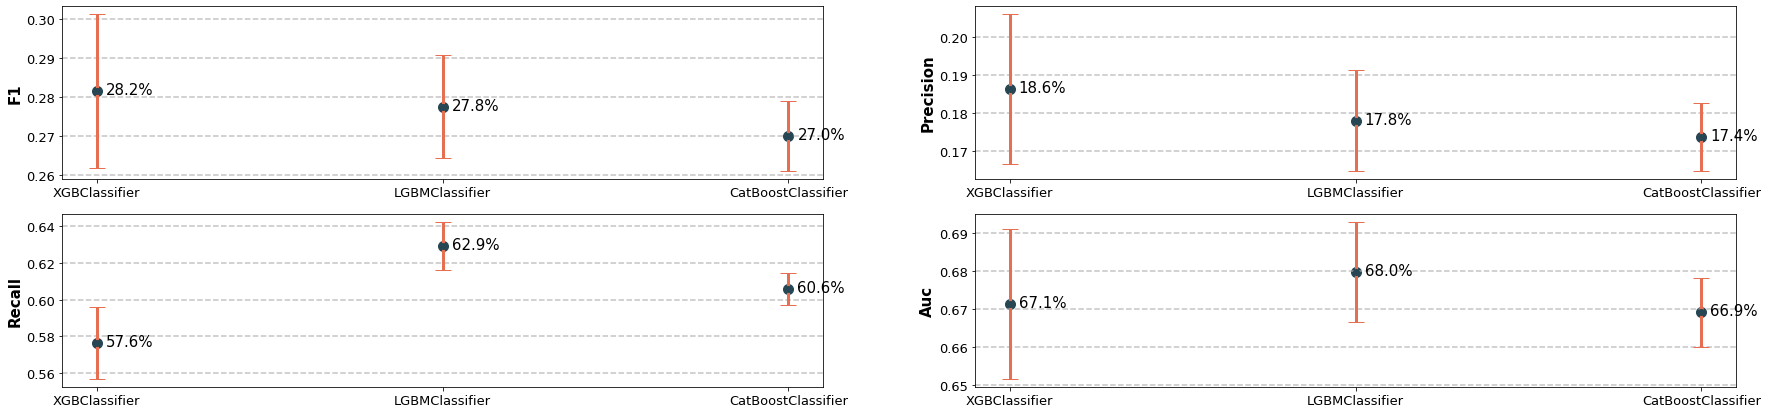

In [172]:
model_names = ['XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']
std_by_model = np.array([np.std([hard_metrics_train.loc[model], hard_metrics_val.loc[model], hard_metrics_test.loc[model]], axis=0) for model in model_names])
metrics_results = np.array([[hard_metrics_test[v][x] for x in model_names] for v in ["f1_test", "precision_test", "recall_test", "auc_test"]])

metrics_result(std_by_model, model_names, metrics_results)

### <a id='4'>4. Really hard intepretability</a>
----

In this section a neural network is trained.    
A neural network is constructed with weighted loss function, and dropout.

In [ ]:
class DenseModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.linear1 = Linear(48, 1024) 
        self.linear2 = Linear(1024, 512) 
        self.linear3 = Linear(512, 128) 
        self.linear4 = Linear(128, 64) 
        self.lin = Linear(64, 2)

    def forward(self, x):
        torch.manual_seed(0)
        
        x = F.dropout(F.relu(self.linear1(x)), p=0.1, training=self.training)
        x = F.dropout(F.relu(self.linear2(x)), p=0.1, training=self.training)
        x = F.dropout(F.relu(self.linear3(x)), p=0.1, training=self.training)
        x = F.dropout(F.relu(self.linear4(x)), p=0.1, training=self.training)
        x = self.lin(x)
        x = F.sigmoid(x)
        return x

input_train = torch.tensor(df_train_graph_numeric_scaled, dtype=torch.float)
input_val = torch.tensor(df_val_graph_numeric_scaled, dtype=torch.float)
input_test = torch.tensor(df_test_graph_numeric_scaled, dtype=torch.float)

target_train = torch.tensor(df_train_graph["TARGET"].values, dtype=torch.long)
target_val = torch.tensor(df_val_graph["TARGET"].values, dtype=torch.long)
target_test = torch.tensor(df_test["TARGET"][:2000].values, dtype=torch.long)

The training and validation functions are defined below.

In [152]:
torch.manual_seed(0)
def train(data):

    torch.manual_seed(0)
    model_pytorch.train()
    optimizer.zero_grad()
    out = model_pytorch(input_train)    
    loss = criterion(out, target_train)
    loss.backward()
    optimizer.step()

    pred = out.max(1)[1]
    f1, precision, recall, auc = metrics_return(df_train_graph["TARGET"], pred)
    return float(loss), f1, precision, recall, auc

def val(data, target):

    torch.manual_seed(0)
    model_pytorch.eval()
    out = model_pytorch(data)
    pred = out.max(1)[1]
    f1, precision, recall, auc = metrics_return(target, pred)
    return f1, precision, recall, auc

The criterias are stablished

In [153]:
model_pytorch = DenseModel()

optimizer = torch.optim.Adam(model_pytorch.parameters(), lr=0.01)
y = np.array(df_train_graph["TARGET"])
weights = [1 - (len(y[y == 0])/len(y)), 1 - (len(y[y == 1])/len(y))]
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights))

The model is trainned

In [154]:
torch.manual_seed(0)
for epoch in range(1, 10 + 1):
    torch.manual_seed(0)
    loss, f1_train, precision_train, recall_train, auc_train = train(df_train_graph_numeric_scaled)
    f1_val, precision_val, recall_val, auc_val = val(input_val, target_val)
    f1_test, precision_test, recall_test, auc_test = val(input_test, target_test)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.3f}, | F1 Train: {f1_train:.3f}, F1 Val: {f1_val:.3f}, F1 Test: {f1_test:.3f}, | Precision Train: {precision_train:.3f}, Precision Val: {precision_val:.3f}, Precision Test: {precision_test:.3f}, | Recall Train: {recall_train:.3f}, Recall Val: {recall_val:.3f}, Recall Test: {recall_test:.3f}, | AUC Train: {auc_train:.3f}, AUC Val: {auc_val:.3f}, AUC Test: {auc_test:.3f}')

Epoch: 010, Loss: 0.607, | F1 Train: 0.241, F1 Val: 0.238, F1 Test: 0.266, | Precision Train: 0.143, Precision Val: 0.143, Precision Test: 0.165, | Recall Train: 0.754, Recall Val: 0.721, Recall Test: 0.688, | AUC Train: 0.686, AUC Val: 0.677, AUC Test: 0.682


Function to get the predictions

In [148]:
def pytorch_predictions(data):
    to_pred = torch.tensor(data, dtype=torch.float)
    model_pytorch.eval()
    out = model_pytorch(to_pred)
    pred = out.max(1)[1]
    return pred

Predictions

In [155]:
y_pred_train = pytorch_predictions(df_train_graph_numeric_scaled)
y_pred_val = pytorch_predictions(df_val_graph_numeric_scaled)
y_pred_test = pytorch_predictions(df_test_graph_numeric_scaled)

The results seems promising, however, we will see if we can improve them with the next model.

In [156]:
f1, precision, recall, auc = metrics_return(df_train_graph["TARGET"], y_pred_train)
print("Train F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, AUC: {:.4f}".format(f1, precision, recall, auc))
f1_val, precision_val, recall_val, auc_val = metrics_return(df_val_graph["TARGET"], y_pred_val)
print("Val F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, AUC: {:.4f}".format(f1_val, precision_val, recall_val, auc_val))
f1_test, precision_test, recall_test, auc_test = metrics_return(df_test["TARGET"][:2000], y_pred_test)
print("Test F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, AUC: {:.4f}".format(f1_test, precision_test, recall_test, auc_test))

Train F1: 0.2467, Precision: 0.1484, Recall: 0.7302, AUC: 0.6871
Val F1: 0.2384, Precision: 0.1428, Recall: 0.7212, AUC: 0.6770
Test F1: 0.2662, Precision: 0.1650, Recall: 0.6882, AUC: 0.6824


Pytorch metrics are added to the existing dataframe

In [187]:
def including_pytorch_metrics(hard_metrics,list_metrics):

    hard_metrics.loc[len(hard_metrics)] = list_metrics
    hard_metrics.rename(index={4: "PyTorch"}, inplace=True)
    return hard_metrics

Metrics are added to the dataframe

In [185]:
hard_metrics_train = including_pytorch_metrics(hard_metrics_train, [f1, precision, recall, auc])
hard_metrics_val = including_pytorch_metrics(hard_metrics_val, [f1_val, precision_val, recall_val, auc_val])
hard_metrics_test = including_pytorch_metrics(hard_metrics_test, [f1_test, precision_test, recall_test, auc_test])

### <a id='5'>5. Saving relevant metrics</a>
----

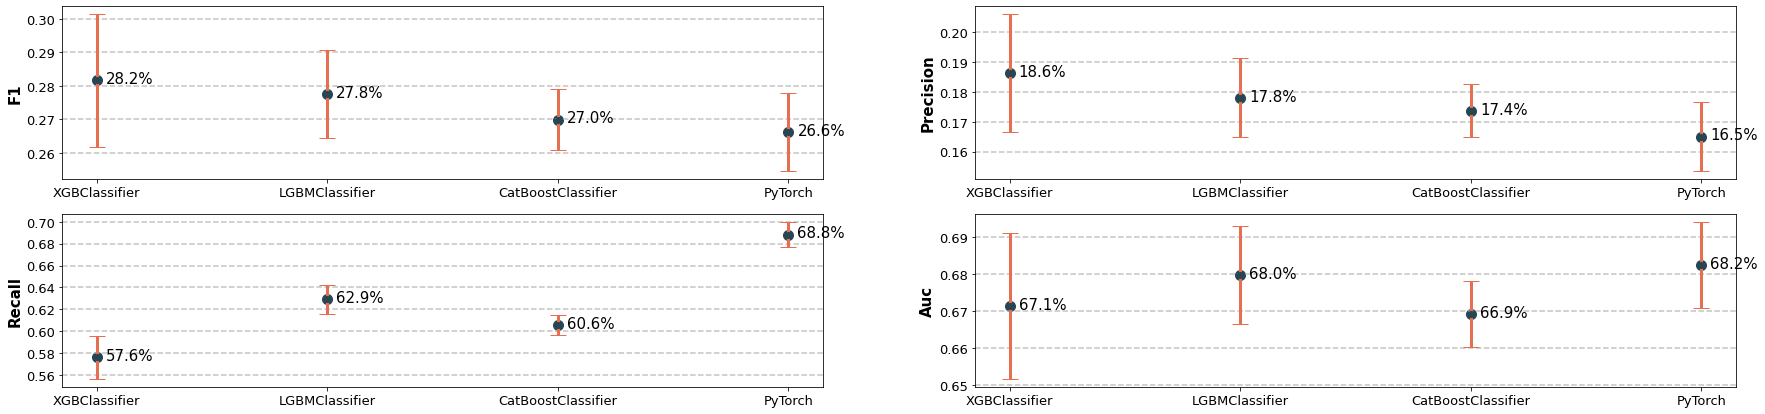

In [191]:
model_names = ['XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier', 'PyTorch']
std_by_model = np.array([np.std([hard_metrics_train.loc[model], hard_metrics_val.loc[model], hard_metrics_test.loc[model]], axis=0) for model in model_names])
metrics_results = np.array([[hard_metrics_test[v][x] for x in model_names] for v in ["f1_test", "precision_test", "recall_test", "auc_test"]])

metrics_result(std_by_model, model_names, metrics_results)

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    import itertools
    fig = plt.figure(figsize=(15,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 15), plt.yticks(tick_marks, classes, fontsize = 15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize = 15,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 18), plt.xlabel('Predicted label', fontsize = 18), plt.title(title, fontsize = 19, fontweight='bold')
    plt.tight_layout()

---

In [87]:
xent = tf.keras.losses.BinaryCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.NONE)

In [88]:
tf.random.set_seed(42)
np.random.seed(42)

from tensorflow.keras import regularizers
model = Sequential()
model.add(Dense(1024, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(Dropout(0.2))
model.add(Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=xent, metrics=["AUC",'Recall'])
model.fit(df_train_graph_numeric_scaled, df_train_graph["TARGET"], epochs=50, batch_size=16, validation_data=(df_val_graph_numeric_scaled, df_val_graph["TARGET"]))

Epoch 1/50
1000/1000 [==============================] - 9s 8ms/step - loss: 0.2725 - auc: 0.6767 - recall: 0.0024 - val_loss: 0.2549 - val_auc: 0.7230 - val_recall: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2578 - auc: 0.7141 - recall: 0.0032 - val_loss: 0.2544 - val_auc: 0.7260 - val_recall: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2508 - auc: 0.7326 - recall: 0.0088 - val_loss: 0.2605 - val_auc: 0.7144 - val_recall: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2501 - auc: 0.7358 - recall: 0.0064 - val_loss: 0.2538 - val_auc: 0.7279 - val_recall: 0.0102
Epoch 5/50
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2457 - auc: 0.7455 - recall: 0.0152 - val_loss: 0.2517 - val_auc: 0.7278 - val_recall: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2439 - auc: 0.7501 - recall: 0.0168 - val_loss

In [89]:
y_pred_train = model.predict(df_train_graph_numeric_scaled)
y_pred_val = model.predict(df_val_graph_numeric_scaled)
y_pred_test = model.predict(df_test_graph_numeric_scaled)

63/63 [==============================] - 0s 2ms/step


In [94]:
f1, precision, recall, auc = metrics_return(df_train_graph["TARGET"], y_pred_train.round())
print("Train F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, AUC: {:.4f}".format(f1, precision, recall, auc))
f1_val, precision_val, recall_val, auc_val = metrics_return(df_val_graph["TARGET"], y_pred_val.round())
print("Val F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, AUC: {:.4f}".format(f1_val, precision_val, recall_val, auc_val))
f1_test, precision_test, recall_test, auc_test = metrics_return(df_test["TARGET"][:2000], y_pred_test.round())
print("Test F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, AUC: {:.4f}".format(f1_test, precision_test, recall_test, auc_test))

Train F1: 0.8828, Precision: 0.9357, Recall: 0.8356, AUC: 0.9154
Val F1: 0.1284, Precision: 0.1724, Recall: 0.1023, AUC: 0.5303
Test F1: 0.0976, Precision: 0.1579, Recall: 0.0706, AUC: 0.5178


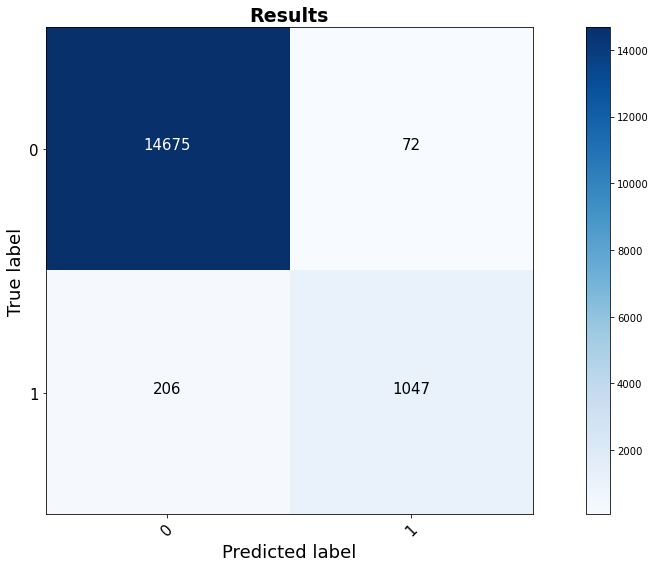

In [90]:
nf_matrix = confusion_matrix(df_train_graph["TARGET"], y_pred_train.round())
plot_confusion_matrix(nf_matrix, classes = ['0', '1'],
                      title='Results')